In [1]:
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
batch_size = 64
width, height, channel = 400, 400, 3
no_epochs = 10
verbosity = 2
input_shape = (width, height, channel)

In [3]:
# ResNet50 모델 사용

pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=1000
)

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('preprocessed_data/test',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

# pretrained_model.trainable=True
# set_trainable=False

# for layer in pretrained_model.layers:
#     if layer.name == 'block7c_project_conv':
#         set_trainable=True
#     if set_trainable:
#         layer.trainable=True
#     else:
#         layer.trainable=False


model=Sequential()
    
# model.add(pretrained_model)

for layer in pretrained_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(1, activation='softmax'))

# model.add(MaxPooling2D())
# model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])

Found 2603 images belonging to 2 classes.
Found 650 images belonging to 2 classes.


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)    

In [7]:
es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//batch_size,
                    callbacks= [es_callback],
                    verbose=verbosity,
                   )

Epoch 1/10
40/40 - 31s - loss: 0.7190 - auc: 0.6357 - accuracy: 0.5825 - val_loss: 0.5540 - val_auc: 0.8529 - val_accuracy: 0.7891
Epoch 2/10
40/40 - 28s - loss: 0.5231 - auc: 0.8274 - accuracy: 0.7495 - val_loss: 0.4680 - val_auc: 0.8859 - val_accuracy: 0.8203
Epoch 3/10
40/40 - 28s - loss: 0.4471 - auc: 0.8826 - accuracy: 0.8109 - val_loss: 0.4011 - val_auc: 0.9158 - val_accuracy: 0.8531
Epoch 4/10
40/40 - 29s - loss: 0.4037 - auc: 0.9026 - accuracy: 0.8267 - val_loss: 0.3592 - val_auc: 0.9336 - val_accuracy: 0.8578
Epoch 5/10
40/40 - 29s - loss: 0.3660 - auc: 0.9180 - accuracy: 0.8432 - val_loss: 0.3331 - val_auc: 0.9438 - val_accuracy: 0.8594
Epoch 6/10
40/40 - 29s - loss: 0.3555 - auc: 0.9200 - accuracy: 0.8444 - val_loss: 0.3009 - val_auc: 0.9509 - val_accuracy: 0.8875
Epoch 7/10
40/40 - 29s - loss: 0.3385 - auc: 0.9268 - accuracy: 0.8456 - val_loss: 0.2920 - val_auc: 0.9533 - val_accuracy: 0.8828
Epoch 8/10
40/40 - 28s - loss: 0.2946 - auc: 0.9483 - accuracy: 0.8748 - val_loss: 

In [8]:
prediction = model.predict(valid_generator)

In [9]:
import numpy as np

print(len(prediction[np.where(prediction > 0.5)]))
print(len(prediction[np.where(prediction < 0.5)]))

190
460


In [10]:
prediction

array([[0.15189172],
       [0.02255224],
       [0.08394249],
       [0.9999999 ],
       [0.01366717],
       [0.0106051 ],
       [0.23841159],
       [0.03473021],
       [0.03872425],
       [0.02316464],
       [0.44350776],
       [0.9947226 ],
       [0.05691432],
       [0.00929645],
       [0.9999925 ],
       [0.8704204 ],
       [0.05553194],
       [0.03453016],
       [0.01524448],
       [0.99999726],
       [0.03819453],
       [0.08144267],
       [0.8637163 ],
       [0.0135975 ],
       [0.84572524],
       [0.06590085],
       [0.13747963],
       [0.05553194],
       [0.01429725],
       [0.80952954],
       [0.43571413],
       [0.01252624],
       [0.03819453],
       [0.19302222],
       [0.07232021],
       [0.24030866],
       [0.08144267],
       [0.9518265 ],
       [0.2675531 ],
       [0.22450231],
       [0.20420784],
       [0.10667769],
       [0.40436214],
       [0.01062067],
       [0.00314052],
       [0.6308059 ],
       [0.0106051 ],
       [0.019

In [11]:
model.evaluate(valid_generator)

11/11 [==============================] - 5s 475ms/step - loss: 0.4175 - auc: 0.9580 - accuracy: 0.8000


[0.4174730181694031, 0.9580018520355225, 0.800000011920929]

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

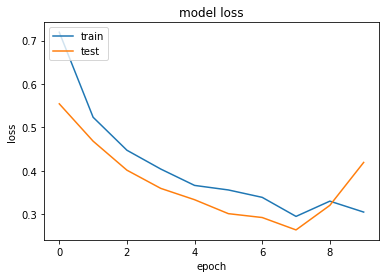

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
from keras.preprocessing import image
img = image.load_img('preprocessed_data/test/positive/positive_0_2404.jpg', target_size=(400, 400, 3))

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([valid_generator[0][0][0][0]])
class_weights = model.layers[-1].get_weights()[0]

InvalidArgumentError: input must be 4-dimensional[400,3] [Op:Conv2D]

In [15]:
valid_generator[0][0][0][0]

array([[0.854902  , 0.6431373 , 0.3529412 ],
       [0.854902  , 0.6156863 , 0.2901961 ],
       [0.86666673, 0.61960787, 0.25490198],
       ...,
       [1.        , 0.90196085, 0.7568628 ],
       [0.9921569 , 0.9686275 , 0.86666673],
       [0.9725491 , 0.9921569 , 0.91372555]], dtype=float32)